In [1]:
# load packages 
%matplotlib inline
import os
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import geopandas as gpd
import pyproj
import shapely.geometry
from shapely.geometry import Point
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
import matplotlib as mpl
import numpy as np
import xarray as xr
import rioxarray as rxr
from geocube.api.core import make_geocube
import xesmf as xe
import cartopy.crs as ccrs
import contextily as ctx
from scipy import stats

# imports for rasterizing 
import geopandas as gpd
import rasterio
from rasterio import features
from rasterio.enums import MergeAlg
from rasterio.plot import show
import xwrf

# dask
import dask
from dask.distributed import Client, LocalCluster

# Load data and presets

In [2]:
# load data and set paths
home_path = Path('/home1/kojoseph/anthropogenic-heat-la-20230205')
data_path = home_path / 'data'
output_path = data_path / 'output'
plot_path = Path('/home1/kojoseph/ah-la-paper/figs')
# load urban area mask (based on WRF-out)
urban_area = gpd.read_file("/home1/kojoseph/ah-la-paper/data/wrf_urban_mask-v2.gpkg")
# load LA County boundary
la_county_filepath='/home1/kojoseph/anthropogenic-heat-la-20230205/data/boundaries/la_county_bound_simplified_3.geojson'
la_county_gdf = gpd.read_file(la_county_filepath)
# load LA City boundary
city_boundaries = gpd.read_file(data_path/'boundaries/City_Boundaries_SCAG_Region.zip')
la_boundary = city_boundaries[city_boundaries.CITY == 'Los Angeles']
la_boundary = la_boundary[['geometry']]
# load highway buffer geometry
highway_buffer = gpd.read_file(data_path / 'boundaries/highway_buffer_1km.gpkg')
highway_buffer = highway_buffer.to_crs('EPSG:4326')
# load neighborhoods 
neighborhoods_dir = data_path / 'boundaries/la_bound_nbhd.geojson'
neighborhoods = gpd.read_file(neighborhoods_dir)

In [3]:
# pre-define labels for easy re-use
# \mathrm{} prevents exprsesion from getting italicized 
# \/ within the latex expression is necessary for an empty space
degree_sign = u'\N{DEGREE SIGN}'
del_ta_label = r'$\mathrm{{\Delta}T_{2m}}$ (' + degree_sign + 'C)'
del_tc_label = r'$\mathrm{{\Delta}T_{c}}$ (' + degree_sign + 'C)'
ahf_label = r'Anthropogenic heat flux ($\mathrm{W\/m^{-2}}$)'
ws_label = r'$\mathrm{{\Delta}}$WS ($\mathrm{m\/s^{-1}}$)'
pblh_label = r'$\mathrm{{\Delta}}$PBLH (m)'
# color shortcutes
max_red = '#DD1717'  # red
yale_blue = '#0F4392'  # blue
# where to save plots
plot_dir ='/home1/kojoseph/ah-la-paper/figs/draft_v1'
os.makedirs(plot_dir, exist_ok=True)

# AHF Distribution Analysis

## AHF Heatmaps

In [4]:
diurnal_path = output_path / '20231124/diurnal/08/weekday'
ahf_t = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_traffic.feather')
ahf_b = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_building.feather')
ahf_m = gpd.read_feather(diurnal_path / 'ahf_diurnal_control_metabolism.feather')
filename = 'ahf_diurnal_control_all.feather'
file_path = output_path / '20231124/diurnal/08/weekday' / filename
ahf_all = gpd.read_feather(file_path)

In [5]:
# create daily avg AHF dataframe
ahf_dict = {'t':ahf_t, 'b':ahf_b, 'm':ahf_m}
ahf_avg_dict = {}
for key in ahf_dict:
    df = ahf_dict[key]
    ahf_avg_dict[key] = df.iloc[:, -24:].mean(axis=1)
    
ahf_avg = ahf_t[['FID', 'geometry']].copy()
for key in ahf_avg_dict:
    column_label = 'ahf_' + key
    ahf_avg.insert(len(ahf_avg.columns), column_label, ahf_avg_dict[key])
ahf_avg['ahf_tot'] = ahf_avg['ahf_t'] + ahf_avg['ahf_b'] + ahf_avg['ahf_m']
ahf_avg.head()

,FID,geometry,ahf_t,ahf_b,ahf_m,ahf_tot
0,832323,"POLYGON ((-118.45759 33.95103, -118.45759 33.9...",0.0,0.0,0.0,0.0
1,832324,"POLYGON ((-118.45761 33.95103, -118.45807 33.9...",0.0,0.0,0.0,0.0
2,832325,"POLYGON ((-118.45807 33.95177, -118.45849 33.9...",0.0,0.0,0.0,0.0
3,830804,"POLYGON ((-118.45849 33.95252, -118.45849 33.9...",0.0,0.0,0.0,0.0
4,830805,"POLYGON ((-118.45853 33.95252, -118.45899 33.9...",0.0,0.0,0.0,0.0


In [6]:
# create daily maximum (hr 13) ahf dataframe
ahf_val_dict = {}
for key, df in ahf_dict.items():
    ahf_val_dict[key] = df['ahf_13']   # pick the single column

# Build new GeoDataFrame with FID + geometry
ahf_max = ahf_t[['FID', 'geometry']].copy()

# Insert the selected ahf_13 values
for key in ahf_val_dict:
    column_label = 'ahf_' + key
    ahf_max.insert(len(ahf_max.columns), column_label, ahf_val_dict[key])

# Compute total
ahf_max['ahf_tot'] = ahf_max['ahf_t'] + ahf_max['ahf_b'] + ahf_max['ahf_m']

ahf_max.head()

,FID,geometry,ahf_t,ahf_b,ahf_m,ahf_tot
0,832323,"POLYGON ((-118.45759 33.95103, -118.45759 33.9...",0.0,0.0,0.0,0.0
1,832324,"POLYGON ((-118.45761 33.95103, -118.45807 33.9...",0.0,0.0,0.0,0.0
2,832325,"POLYGON ((-118.45807 33.95177, -118.45849 33.9...",0.0,0.0,0.0,0.0
3,830804,"POLYGON ((-118.45849 33.95252, -118.45849 33.9...",0.0,0.0,0.0,0.0
4,830805,"POLYGON ((-118.45853 33.95252, -118.45899 33.9...",0.0,0.0,0.0,0.0


In [7]:
# Rasterize into xarray dataset
# Assume gdf is your large GeoDataFrame
gdf_m = ahf_max.to_crs(epsg=32611)  # project to meters (important!)

# Choose your target resolution (50 meters)
resolution = 100

# Floor coordinates to nearest multiple of 50 m
gdf_m["x"] = (gdf_m.geometry.centroid.x // resolution) * resolution
gdf_m["y"] = (gdf_m.geometry.centroid.y // resolution) * resolution

# Find unique sorted coordinates
x_coords = np.sort(gdf_m["x"].unique())
y_coords = np.sort(gdf_m["y"].unique())[::-1]  # descending so north at top

nx = len(x_coords)
ny = len(y_coords)

# build mapping from coordinate value -> array index
x_index = {x: i for i, x in enumerate(x_coords)}
y_index = {y: i for i, y in enumerate(y_coords)}

# Convert x/y to index arrays (vectorized)
x_idx = gdf_m["x"].map(x_index).to_numpy()
y_idx = gdf_m["y"].map(y_index).to_numpy()

# Build data variables
data_vars = {}
for col in ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]:
    arr = np.full((ny, nx), np.nan, dtype="float32")
    arr[y_idx, x_idx] = gdf_m[col].to_numpy()
    data_vars[col] = (("y", "x"), arr)

# Build xarray Dataset
ds = xr.Dataset(
    data_vars=data_vars,
    coords={"x": x_coords, "y": y_coords},
    attrs={"crs": gdf_m.crs.to_string(), "resolution": 100} # insert target resolution
)

print(ds)

<xarray.Dataset>
Dimensions:  (y: 1250, x: 1211)
Coordinates:
  * x        (x) float64 3.2e+05 3.201e+05 3.202e+05 ... 4.409e+05 4.41e+05
  * y        (y) float64 3.854e+06 3.854e+06 3.854e+06 ... 3.73e+06 3.73e+06
Data variables:
    ahf_t    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_b    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_m    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
    ahf_tot  (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    crs:         EPSG:32611
    resolution:  100


In [8]:
# remove everything under 0.1 W/m2 (turn to nan)
ds_nonan = ds.where(ds >= 0.1, np.nan)

In [9]:
# What are the CRS's of the dfs?
print(ds_nonan.crs)
print(la_county_gdf.crs)

EPSG:32611
epsg:4326


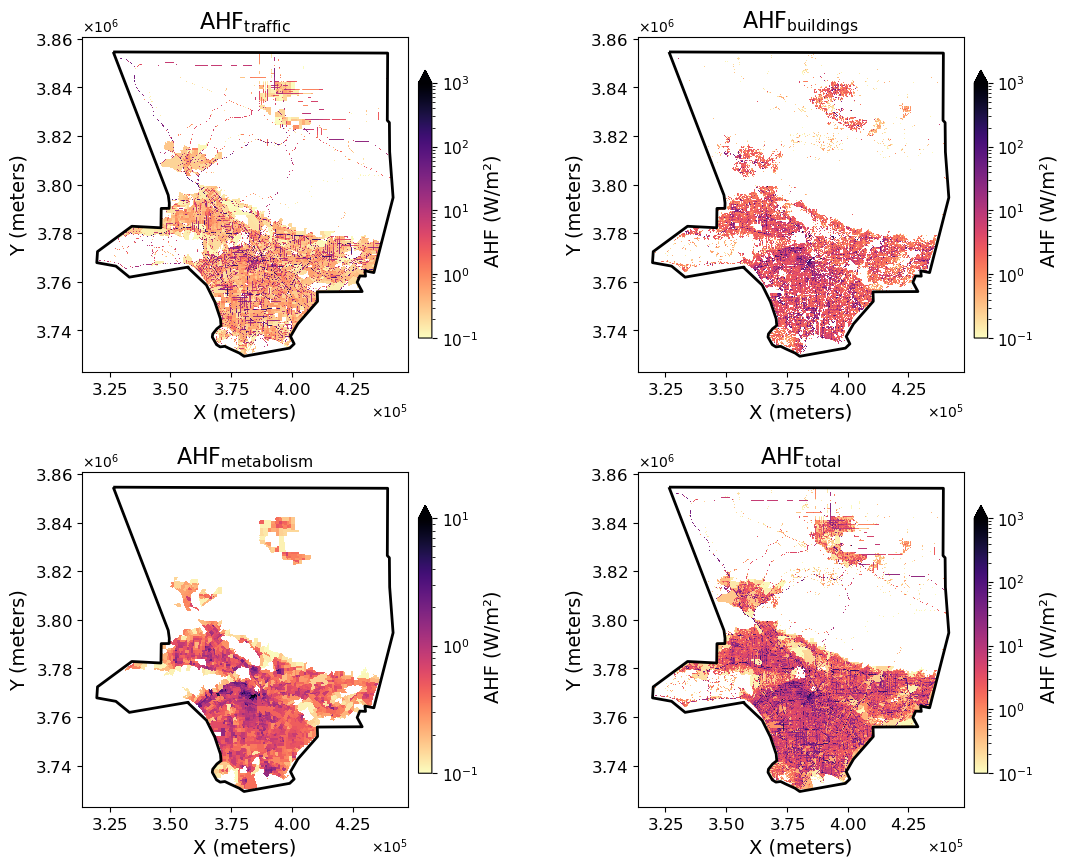

In [10]:
# Reproject LA County GeoDataFrame
la_county_gdf_utm = la_county_gdf.to_crs(ds_nonan.crs)

variables = ["ahf_t", "ahf_b", "ahf_m", "ahf_tot"]
cmaps = ["magma_r"]*4
vmax_values = [1000, 1000, 10, 1000]
vmin = 0.1
titles = [r"AHF$_{\mathrm{traffic}}$", r"AHF$_{\mathrm{buildings}}$",
          r"AHF$_{\mathrm{metabolism}}$", r"AHF$_{\mathrm{total}}$"]

# Create figure with gridspec
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(2, 2, wspace=0.05, hspace=0.3)  # set spacing here

title_fs = 16
label_fs = 14
tick_fs = 12
cb_label_fs = 14

for i, var in enumerate(variables):
    ax = fig.add_subplot(gs[i])
    
    # Plot data without colorbar
    im = ds_nonan[var].plot.imshow(
        x='x', y='y',
        cmap=cmaps[i],
        norm=LogNorm(vmin=vmin, vmax=vmax_values[i]),
        interpolation='none',
        ax=ax,
        add_colorbar=False
    )
    
    # Overlay LA County boundary
    la_county_gdf_utm.boundary.plot(ax=ax, color='black', linewidth=2)

    ax.set_aspect('equal')
    ax.set_title(titles[i], fontsize=title_fs)
    ax.set_xlabel("X (meters)", fontsize=label_fs)
    ax.set_ylabel("Y (meters)", fontsize=label_fs)
    
    # Axes formatting
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.tick_params(labelsize=tick_fs)
    
    # Add colorbar manually
    cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.02, extend='max')
    cbar.set_label("AHF (W/m²)", fontsize=cb_label_fs)
    cbar.ax.tick_params(labelsize=tick_fs-1)

save_path = plot_path / 'draft_v1/ahf_plots.png'
# fig.savefig(save_path, dpi=300, bbox_inches='tight') # save plot
plt.show()

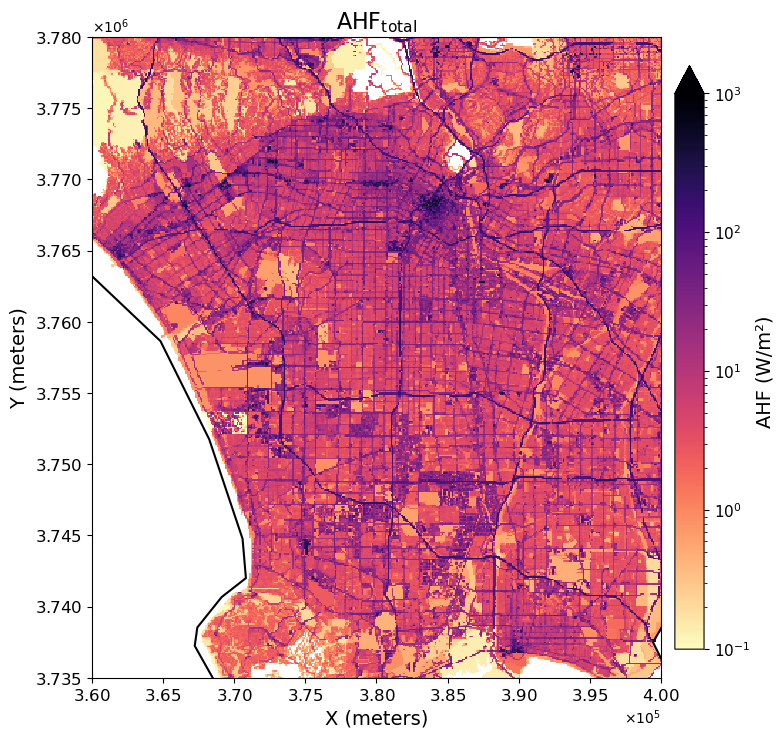

In [11]:
# Reproject LA County boundary to match xarray CRS
la_county_gdf_utm = la_county_gdf.to_crs(ds_nonan.crs)

# Select variable
var = "ahf_tot"
vmin = 0.1
vmax = 1000
cmap = "magma_r"
title = r"AHF$_{\mathrm{total}}$"

# Define zoomed-in limits (in meters, adjust as needed)
xlim_zoom = (3.6e5, 4.0e5)
ylim_zoom = (3.735e6, 3.78e6)

fig, ax = plt.subplots(figsize=(8, 8))  # square figure is fine, aspect is set by CRS

# Plot
im = ds_nonan[var].plot.imshow(
    x='x',
    y='y',
    cmap=cmap,
    norm=LogNorm(vmin=vmin, vmax=vmax),
    interpolation='none',
    ax=ax,
    add_colorbar=False
)

# Overlay LA County boundary
la_county_gdf_utm.boundary.plot(ax=ax, color='black', linewidth=1.5)

# Set zoomed-in limits
ax.set_xlim(xlim_zoom)
ax.set_ylim(ylim_zoom)

# Maintain true CRS aspect ratio (meters in x and y are equal)
ax.set_aspect('equal')

ax.set_title(title, fontsize=16)
ax.set_xlabel("X (meters)", fontsize=14)
ax.set_ylabel("Y (meters)", fontsize=14)

# Scientific notation for axes
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(labelsize=12)

# Add colorbar
cbar = plt.colorbar(im, ax=ax, shrink=0.8, pad=0.02, extend='max')
cbar.set_label("AHF (W/m²)", fontsize=14)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
save_path = plot_path / 'draft_v1/ahf_total_zoom.png'
# fig.savefig(save_path, dpi=300, bbox_inches='tight') # save plot
plt.show()


## Diurnal Plots

In [12]:
# create diurnal ahf dataframe
ahf_all_avg = ahf_all.describe()
ahf_cols = [f"ahf_{i}" for i in range(24)]
# === LA County (ahf_all) === 
ahf_all_arr = ahf_all_avg.drop('FID', axis=1).loc['mean'].array
std_all_arr = ahf_all_avg.drop('FID', axis=1).loc['std'].array
# === Urban areas within LA County (ahf_urban) ===
ahf_urban = ahf_all.sjoin(urban_area, predicate='within')
# ahf_urban.drop('index_right', axis=1, inplace=True)
# ahf_urban_avg = ahf_urban.iloc[:,-24:].describe()
# ahf_urban_arr = ahf_urban_avg.loc['mean'].array
ahf_urban_arr = ahf_urban[ahf_cols].mean(axis=0)
# === City of LA (ahf_la) ===
ahf_la = ahf_all.sjoin(la_boundary, predicate='within')
# ahf_la.drop(columns = ['index_right', 'geometry'],inplace=True)
# ahf_la_avg = ahf_la.iloc[:,-24:].describe()
# ahf_la_arr = ahf_la_avg.loc['mean'].array
ahf_la_arr = ahf_la[ahf_cols].mean(axis=0)
# === Near highways within LA County (ahf_near_highway) === 
ahf_near_highway = ahf_all.sjoin(highway_buffer, predicate='within')
# ahf_near_highway.drop(columns=['index_right'], inplace=True)
# ahf_near_highway_avg = ahf_near_highway.describe()
# ahf_near_highway_arr = ahf_near_highway_avg.drop('FID', axis=1).loc['mean'].array
# std_near_highway_arr = ahf_near_highway_avg.drop('FID', axis=1).loc['std'].array
ahf_near_highway_arr = ahf_near_highway[ahf_cols].mean(axis=0)
std_near_highway_arr = ahf_near_highway[ahf_cols].std(axis=0)

# combine into single df 
hr_of_day = range(24)
df = pd.DataFrame({'hr':hr_of_day,
                   'ahf_near_highway':ahf_near_highway_arr,
                   'ahf_all':ahf_all_arr,
                   'ahf_la':ahf_la_arr,
                   'ahf_urban':ahf_urban_arr,
                  'std_near_highway':std_near_highway_arr,
                  'std_all':std_all_arr})

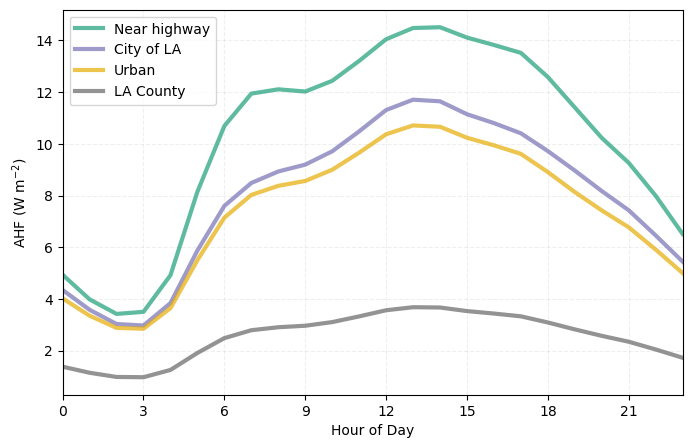

In [13]:
ahf_cols = ['ahf_near_highway', 'ahf_la', 'ahf_urban', 'ahf_all']
legend_labels = ['Near highway', 'City of LA', 'Urban', 'LA County']
fig, ax = plt.subplots(figsize=(8,5))
df.plot(ax=ax, x='hr', y=ahf_cols, cmap='Dark2', linewidth=3, alpha=0.7)
ax.legend(legend_labels, loc='upper left')
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.set_ylabel('AHF (W m$^{-2}$)')
ax.set_xlabel('Hour of Day')
ax.set_xlim(0, 23)
ax.grid(True, linestyle='--', alpha=0.2)
filename = 'ahf_lineplot_by_agg_20231209.png'
save_path = plot_path / 'neighborhood' / filename
# plt.savefig(save_path, dpi=300)

## Neighborhood analysis

In [14]:
# Remove Catalina Island (including Avalon) from dataframe
catalina_index = neighborhoods.query('name.str.contains("Catalina") | name.str.contains("Avalon")').index
neighborhoods.drop(catalina_index, inplace=True)
# make neighborhoods name all lower-case to match energy atlas name column
neighborhoods['name'] = neighborhoods['name'].str.lower()
neighborhoods.head()

,external_i,name,location,latitude,slug_1,sqmi,display_na,set,slug,longitude,name_1,kind,type,geometry
0,acton,acton,POINT(34.497355239240846 -118.16981019229348),-118.16981019229348,None,39.3391089485,Acton L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),acton,34.497355239240846,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894..."
1,adams-normandie,adams-normandie,POINT(34.031461499124156 -118.30020800000011),-118.30020800000011,None,0.805350187789,Adams-Normandie L.A. County Neighborhood (Curr...,L.A. County Neighborhoods (Current),adams-normandie,34.031461499124156,None,L.A. County Neighborhood (Current),segment-of-a-city,"MULTIPOLYGON (((-118.30901 34.03741, -118.3004..."
2,agoura-hills,agoura hills,POINT(34.146736499122795 -118.75988450000015),-118.75988450000015,None,8.14676029818,Agoura Hills L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agoura-hills,34.146736499122795,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.76193 34.16820, -118.7263..."
3,agua-dulce,agua dulce,POINT(34.504926999796837 -118.3171036690717),-118.3171036690717,None,31.4626319451,Agua Dulce L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),agua-dulce,34.504926999796837,None,L.A. County Neighborhood (Current),unincorporated-area,"MULTIPOLYGON (((-118.25468 34.55830, -118.2555..."
4,alhambra,alhambra,POINT(34.085538999123571 -118.13651200000021),-118.13651200000021,None,7.62381430605,Alhambra L.A. County Neighborhood (Current),L.A. County Neighborhoods (Current),alhambra,34.085538999123571,None,L.A. County Neighborhood (Current),standalone-city,"MULTIPOLYGON (((-118.12175 34.10504, -118.1168..."


<AxesSubplot: >

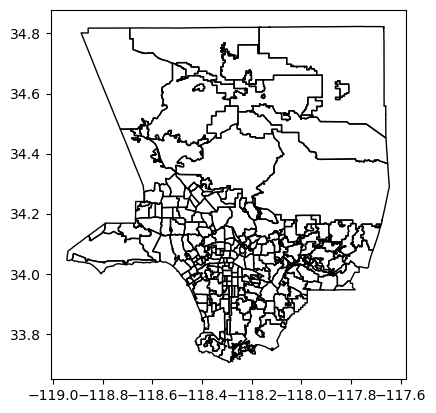

In [15]:
neighborhoods.plot(facecolor='None')

### Daily average

In [16]:
ahf_agg_hoods = ahf_avg.sjoin(neighborhoods, how='left', predicate='intersects')
ahf_agg_hoods.head()

,FID,geometry,ahf_t,ahf_b,ahf_m,ahf_tot,index_right,external_i,name,location,latitude,slug_1,sqmi,display_na,set,slug,longitude,name_1,kind,type
0,832323,"POLYGON ((-118.45759 33.95103, -118.45759 33.9...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,832324,"POLYGON ((-118.45761 33.95103, -118.45807 33.9...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,832325,"POLYGON ((-118.45807 33.95177, -118.45849 33.9...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,830804,"POLYGON ((-118.45849 33.95252, -118.45849 33.9...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,830805,"POLYGON ((-118.45853 33.95252, -118.45899 33.9...",0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
col_list = ['FID', 'name', 'ahf_b', 
            'ahf_m', 'ahf_t','ahf_tot']
df = ahf_agg_hoods[col_list].copy()
fill_cols = []
for column in df.columns:
    if ('ahf' in column):
        fill_cols.append(column)
df[fill_cols] = df[fill_cols].fillna(0)
df.head()

,FID,name,ahf_b,ahf_m,ahf_t,ahf_tot
0,832323,NaN,0.0,0.0,0.0,0.0
1,832324,NaN,0.0,0.0,0.0,0.0
2,832325,NaN,0.0,0.0,0.0,0.0
3,830804,NaN,0.0,0.0,0.0,0.0
4,830805,NaN,0.0,0.0,0.0,0.0


In [18]:
df_sum = df.groupby('name', as_index=False).agg({'name':'first',
                                                 'ahf_b':'mean',
                                                 'ahf_m':'mean',
                                                 'ahf_t':'mean',
                                                'ahf_tot':'mean'})
df_sum

,name,ahf_b,ahf_m,ahf_t,ahf_tot
0,acton,0.057224,0.003927,0.587169,0.648320
1,adams-normandie,2.947090,0.807480,14.058099,17.812669
2,agoura hills,1.273868,0.094300,3.320174,4.688342
3,agua dulce,0.037293,0.004425,0.471916,0.513634
4,alhambra,3.734459,0.431976,5.504542,9.670976
...,...,...,...,...,...
265,willowbrook,3.533304,0.375009,4.826221,8.734534
266,wilmington,3.637290,0.258838,3.325355,7.221482
267,windsor square,4.455653,0.430984,4.739339,9.625975
268,winnetka,2.960839,0.409690,3.291327,6.661856


In [19]:
df_sum_sorted = df_sum.sort_values(by='ahf_tot', ascending=False)

In [20]:
df = df_sum_sorted
df['f_traffic'] = df['ahf_t']/df['ahf_tot']
df['f_building'] = df['ahf_b']/df['ahf_tot']
df['f_metabolism'] = df['ahf_m']/df['ahf_tot']
df_sum_sorted.head(20)

,name,ahf_b,ahf_m,ahf_t,ahf_tot,f_traffic,f_building,f_metabolism
59,downtown,19.706390,1.113406,15.449724,36.269520,0.425970,0.543332,0.030698
230,university park,17.148950,1.008464,16.689608,34.847022,0.478939,0.492121,0.028940
229,universal city,21.325421,0.366269,12.702402,34.394092,0.369319,0.620032,0.010649
38,century city,26.432222,1.308241,6.577272,34.317735,0.191658,0.770220,0.038121
74,elysian valley,2.769894,0.307545,24.570172,27.647611,0.888691,0.100186,0.011124
259,westlake,11.904674,1.605122,11.832863,25.342658,0.466915,0.469748,0.063337
172,pico-union,6.187018,0.989541,16.487277,23.663837,0.696729,0.261455,0.041817
103,hollywood,12.642239,0.977089,7.658878,21.278206,0.359940,0.594140,0.045920
198,sawtelle,7.444815,0.668263,12.831060,20.944138,0.612633,0.355461,0.031907
112,koreatown,12.511621,1.513304,6.690153,20.715078,0.322961,0.603986,0.073053


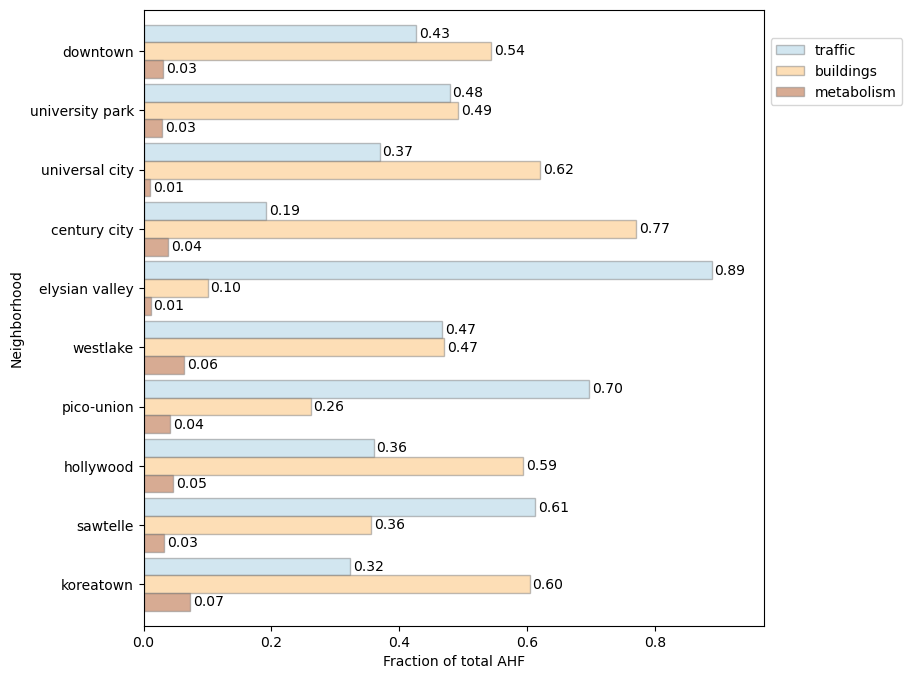

In [21]:
# plot grouped proportions for top 10
df = df_sum_sorted.head(10)
df = df[['name', 'f_traffic', 'f_building', 'f_metabolism']]
fig, ax = plt.subplots(figsize=(8,8))
df.plot(ax=ax, kind='barh', x='name', 
        width=0.9, alpha=0.5, cmap='Paired',
       edgecolor='gray')
ax.invert_yaxis()

for x in ax.containers:
    ax.bar_label(x, padding=2, fmt='%.2f')
ax.set_xlim(0, 0.97)
# ax.set_ylim(0, 0.97)
ax.set_ylabel('Neighborhood')
ax.set_xlabel('Fraction of total AHF')
legend_labels = ['traffic', 'buildings', 'metabolism']
plt.legend(legend_labels, loc='center left', bbox_to_anchor=(1.0, 0.9))

filename = 'barplot_f_sector_top10.png'
file_path = plot_path / '20231206' / filename
# plt.savefig(file_path, dpi=300, bbox_inches='tight')
# issue with plot saving with sides cut off, use bbox_inches parameter

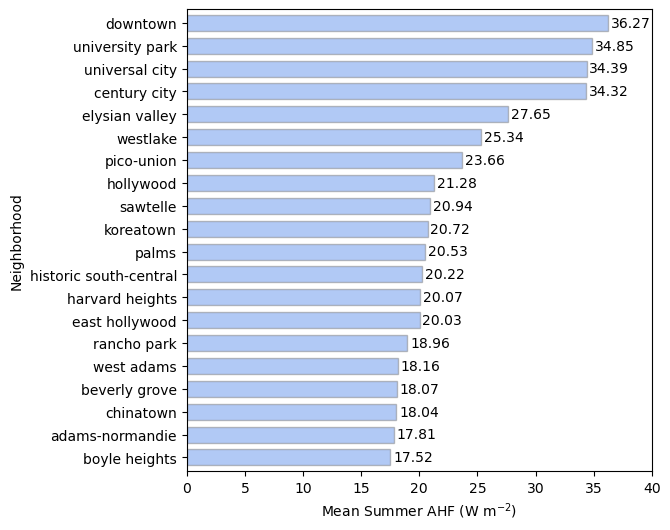

In [22]:
# plot ahf_total for top 20
df = df_sum_sorted.head(20)
df = df[['name', 'ahf_tot']]
fig, ax = plt.subplots(figsize=(6,6))
df.plot(ax=ax, kind='barh', x='name', 
        edgecolor='gray', color='cornflowerblue',
        alpha=0.5, width=0.7, legend=False)
ax.bar_label(ax.containers[0], padding=2, fmt='%.2f')
ax.invert_yaxis()
ax.set_xlim(0, 40)
ax.set_ylabel('Neighborhood')
ax.set_xlabel('Mean Summer AHF (W m$^{-2}$)')
filename = 'barplot_ahf_aug_avg_top20.png'
file_path = plot_path / '20231206' / filename
# plt.savefig(file_path, dpi=300, bbox_inches='tight')

In [23]:
# Which neighborhoods have highest f_traffic?
df = df_sum_sorted
df = df[df.ahf_tot>10]
df.sort_values('f_traffic', ascending=False).head(20)

,name,ahf_b,ahf_m,ahf_t,ahf_tot,f_traffic,f_building,f_metabolism
73,elysian park,0.546039,0.107950,11.084512,11.738502,0.944287,0.046517,0.009196
74,elysian valley,2.769894,0.307545,24.570172,27.647611,0.888691,0.100186,0.011124
242,veterans administration,1.861493,0.274348,13.290495,15.426336,0.861546,0.120670,0.017784
239,vermont vista,2.172150,0.530729,14.714535,17.417414,0.844817,0.124711,0.030471
29,broadway-manchester,2.336711,0.603557,13.989909,16.930177,0.826330,0.138020,0.035650
257,west whittier-los nietos,1.806444,0.334998,9.705630,11.847072,0.819243,0.152480,0.028277
54,del aire,2.553075,0.361472,12.459829,15.374376,0.810428,0.166060,0.023511
147,mission hills,2.257968,0.281205,10.616782,13.155955,0.806994,0.171631,0.021375
9,arleta,1.732179,0.379385,8.814313,10.925877,0.806737,0.158539,0.034724
12,athens,1.976782,0.266537,8.859697,11.103016,0.797954,0.178040,0.024006


In [24]:
# Which neighborhoods have highest f_building?
df = df_sum_sorted
df = df[df.ahf_tot>10]
df.sort_values('f_building', ascending=False).head(20)

,name,ahf_b,ahf_m,ahf_t,ahf_tot,f_traffic,f_building,f_metabolism
70,el segundo,9.751929,0.338575,1.935284,12.025789,0.160928,0.810918,0.028154
38,century city,26.432222,1.308241,6.577272,34.317735,0.191658,0.770220,0.038121
250,west compton,9.169967,0.255956,2.696411,12.122334,0.222433,0.756452,0.021114
179,rancho dominguez,12.310907,0.177823,4.368311,16.857041,0.259139,0.730312,0.010549
23,beverly grove,12.714593,0.807274,4.547856,18.069723,0.251684,0.703641,0.044675
241,vernon,10.128172,0.183881,4.445484,14.757537,0.301235,0.686305,0.012460
253,west hollywood,10.297872,0.768406,4.253845,15.320123,0.277664,0.672179,0.050157
197,santa monica,6.713752,0.592939,3.102806,10.409497,0.298075,0.644964,0.056961
229,universal city,21.325421,0.366269,12.702402,34.394092,0.369319,0.620032,0.010649
77,fairfax,7.640678,0.553076,4.308323,12.502077,0.344609,0.611153,0.044239


In [25]:
# Which neighborhoods have highest ahf_traffic?
df = df_sum_sorted
df = df[df.ahf_tot>10]
df.sort_values('ahf_t', ascending=False).head(20)

,name,ahf_b,ahf_m,ahf_t,ahf_tot,f_traffic,f_building,f_metabolism
74,elysian valley,2.769894,0.307545,24.570172,27.647611,0.888691,0.100186,0.011124
230,university park,17.148950,1.008464,16.689608,34.847022,0.478939,0.492121,0.028940
172,pico-union,6.187018,0.989541,16.487277,23.663837,0.696729,0.261455,0.041817
59,downtown,19.706390,1.113406,15.449724,36.269520,0.425970,0.543332,0.030698
181,rancho park,3.704161,0.395893,14.861729,18.961783,0.783773,0.195349,0.020878
239,vermont vista,2.172150,0.530729,14.714535,17.417414,0.844817,0.124711,0.030471
165,palms,5.346422,0.693089,14.489040,20.528552,0.705799,0.260438,0.033762
1,adams-normandie,2.947090,0.807480,14.058099,17.812669,0.789219,0.165449,0.045332
29,broadway-manchester,2.336711,0.603557,13.989909,16.930177,0.826330,0.138020,0.035650
94,harvard heights,5.728384,0.854392,13.487093,20.069868,0.672007,0.285422,0.042571


In [26]:
# Which neighborhoods have highest ahf_building?
df = df_sum_sorted
df = df[df.ahf_tot>10]
df.sort_values('ahf_b', ascending=False).head(20)

,name,ahf_b,ahf_m,ahf_t,ahf_tot,f_traffic,f_building,f_metabolism
38,century city,26.432222,1.308241,6.577272,34.317735,0.191658,0.770220,0.038121
229,universal city,21.325421,0.366269,12.702402,34.394092,0.369319,0.620032,0.010649
59,downtown,19.706390,1.113406,15.449724,36.269520,0.425970,0.543332,0.030698
230,university park,17.148950,1.008464,16.689608,34.847022,0.478939,0.492121,0.028940
23,beverly grove,12.714593,0.807274,4.547856,18.069723,0.251684,0.703641,0.044675
103,hollywood,12.642239,0.977089,7.658878,21.278206,0.359940,0.594140,0.045920
112,koreatown,12.511621,1.513304,6.690153,20.715078,0.322961,0.603986,0.073053
179,rancho dominguez,12.310907,0.177823,4.368311,16.857041,0.259139,0.730312,0.010549
259,westlake,11.904674,1.605122,11.832863,25.342658,0.466915,0.469748,0.063337
253,west hollywood,10.297872,0.768406,4.253845,15.320123,0.277664,0.672179,0.050157


### Diurnal plots

In [29]:
ahf_hoods_diurnal = ahf_all.sjoin(neighborhoods, how='left', predicate='intersects')
agg_dict = {}
for column in ahf_hoods_diurnal.columns:
    if column == 'name':
        agg_dict[column] = 'first'
    elif 'ahf' in column: 
        agg_dict[column] = 'mean'
col_list = list(agg_dict.keys())
ahf_hoods_diurnal_agg = ahf_hoods_diurnal[col_list]
ahf_hoods_diurnal_agg.head()

,ahf_0,ahf_1,ahf_2,ahf_3,ahf_4,ahf_5,ahf_6,ahf_7,ahf_8,ahf_9,...,ahf_15,ahf_16,ahf_17,ahf_18,ahf_19,ahf_20,ahf_21,ahf_22,ahf_23,name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [30]:
ahf_hoods_diurnal_agg.set_index('name')
ahf_hoods_sums = ahf_hoods_diurnal_agg.groupby('name', as_index=False).agg(agg_dict)
name_column = ahf_hoods_sums.pop('name')
ahf_hoods_sums.insert(0, 'name', name_column)

df = ahf_hoods_sums.set_index('name').T
df = df.sort_values(by='ahf_12', axis=1, ascending=True)
df.reset_index(inplace=True)
new_col = list(df.index)
df.insert(loc=0, column='hr', value=new_col)
df.head()

name,hr,index,angeles crest,lake hughes,northwest antelope valley,northeast antelope valley,leona valley,elizabeth lake,hasley canyon,castaic canyons,...,beverly grove,hollywood,pico-union,koreatown,elysian valley,westlake,universal city,university park,century city,downtown
0,0,ahf_0,0.013164,0.016706,0.034132,0.037646,0.069910,0.080801,0.123923,0.096775,...,10.184692,12.308184,11.387959,12.295614,11.454841,13.657677,20.576149,16.865242,19.772222,17.651177
1,1,ahf_1,0.009556,0.014443,0.025000,0.027823,0.052900,0.061474,0.099852,0.074789,...,8.717003,10.666140,9.048369,10.378232,8.590676,11.317776,19.130495,14.076577,17.600682,15.097883
2,2,ahf_2,0.008197,0.012087,0.021541,0.024072,0.045512,0.053123,0.083837,0.062651,...,6.974980,9.172422,7.741577,8.456247,7.417274,9.358856,18.518590,11.599343,14.946026,12.647760
3,3,ahf_3,0.009118,0.011763,0.023811,0.026577,0.048692,0.055970,0.077855,0.062847,...,6.617023,8.941250,7.941813,7.986785,8.053074,9.133625,18.879173,11.722553,14.482217,12.775594
4,4,ahf_4,0.015861,0.013582,0.040629,0.044889,0.077141,0.085976,0.094211,0.091634,...,7.705884,10.588577,11.396966,9.426113,13.201026,11.665510,21.565855,15.529713,16.143517,16.355910


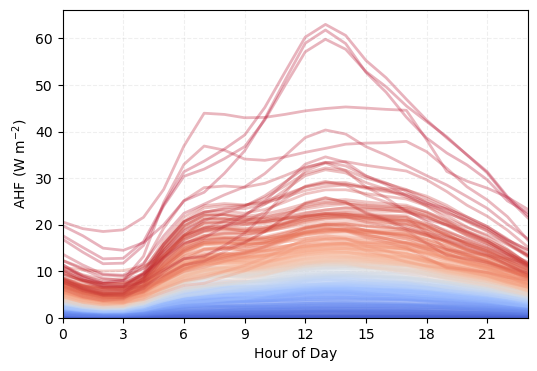

In [32]:
fig, ax = plt.subplots(figsize=(6,4))
df.plot(ax=ax, x='hr', y=list(df.columns[-270:]), legend=False, 
          linewidth = 2, alpha=0.3, cmap='coolwarm')
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.set_ylabel('AHF (W m$^{-2}$)')
ax.set_xlabel('Hour of Day')
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=23)
filename = 'ahf_profiles_neighborhoods_20231209.png'
save_path = plot_path / 'neighborhood' / filename
# plt.savefig(save_path, dpi=300)

In [40]:
# get bottom 5 neighborhoods
df_low = df.iloc[:,:7]
df_low.set_index('index', inplace=True)
df_low = df_low.sort_values(by='ahf_12', axis=1, ascending=False)
df_low.reset_index(inplace=True)

# get top 5 neighborhoods
df_high = df.iloc[:,-5:]
df_high = df_low.iloc[:,:1].join(df_high)
df_high.set_index('index', inplace=True)
df_high = df_high.sort_values(by='ahf_12', axis=1, ascending=False)
df_high.reset_index(inplace=True)
df_high.insert(loc=0, column='hr', value=list(df_high.index))

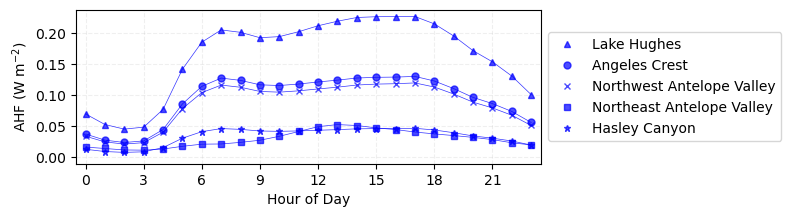

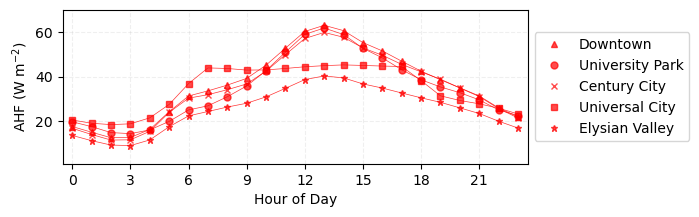

In [42]:
# plot bottom 5 neighborhoods
markers = ['^', 'o', 'x', 's', '*']
fig, ax = plt.subplots(figsize=(6,2))
df_low.plot(ax=ax, x='hr', y=list(df_low.columns[-5:]), 
              alpha=0.7, color='blue', style=markers, ms=5)
df_low.plot(ax=ax, x='hr', y=list(df_low.columns[-5:]), 
          linewidth = 0.5, alpha=0.8, color='blue')
bottom_hoods = ['Lake Hughes', 'Angeles Crest', 'Northwest Antelope Valley',
                 'Northeast Antelope Valley', 'Hasley Canyon']
ax.legend(bottom_hoods, loc='center left', bbox_to_anchor=(1,0.5))
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.set_ylabel('AHF (W m$^{-2}$)')
ax.set_xlabel('Hour of Day')
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_ylim(bottom=-0.01)
ax.set_xlim(left=-0.5, right=23.5)
filename = 'ahf_profiles_bottom5_20231209.png'
save_path = plot_path / 'neighborhood' / filename
# plt.savefig(save_path, dpi=300, bbox_inches='tight')

# plot top 5 neighborhoods
markers = ['^', 'o', 'x', 's', '*']
fig, ax = plt.subplots(figsize=(6,2))
df_high.plot(ax=ax, x='hr', y=list(df_high.columns[-5:]), 
               alpha=0.7, color='red', style=markers, ms=5)
df_high.plot(ax=ax, x='hr', y=list(df_high.columns[-5:]), 
          linewidth = 0.5, alpha=0.8, color='red')
top_hoods = ['Downtown', 'University Park', 'Century City',
                 'Universal City', 'Elysian Valley']
ax.legend(top_hoods, loc='center left', bbox_to_anchor=(1,0.5))
ax.xaxis.set_ticks(np.arange(0, 25, 3))
ax.set_ylabel('AHF (W m$^{-2}$)')
ax.set_xlabel('Hour of Day')
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_ylim(bottom=1, top=70)
ax.set_xlim(left=-0.5, right=23.5)
filename = 'ahf_profiles_top5_20231209.png'
save_path = plot_path / 'neighborhood' / filename
# plt.savefig(save_path, dpi=300, bbox_inches='tight')

In [43]:
# get bottom 5 boundaries
hood_list = [x.lower() for x in bottom_hoods]
hoods_bottom = neighborhoods[neighborhoods['name'].isin(hood_list)]
hoods_bottom = hoods_bottom.to_crs(epsg=3310)
hoods_bottom['centroids'] = hoods_bottom['geometry'].centroid
hoods_bottom.set_geometry('centroids', inplace=True)
hoods_bottom = hoods_bottom.to_crs(neighborhoods.crs)
hoods_bottom = hoods_bottom.set_index('name')
hoods_bottom = hoods_bottom.reindex(hood_list)
# get top 5 boundaries
hood_list = [x.lower() for x in top_hoods]
hoods_top = neighborhoods[neighborhoods['name'].isin(hood_list)]
hoods_top = hoods_top.to_crs(epsg=3310)
hoods_top['centroids'] = hoods_top['geometry'].centroid
hoods_top.set_geometry('centroids', inplace=True)
hoods_top = hoods_top.to_crs(neighborhoods.crs)
hoods_top = hoods_top.set_index('name')
hoods_top = hoods_top.reindex(hood_list)

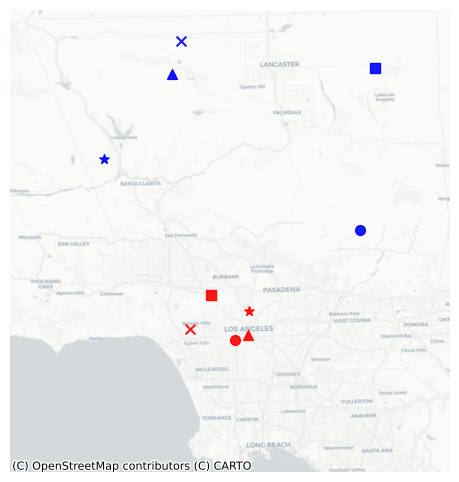

In [45]:
# create map of 
df_bottom = hoods_bottom.to_crs('epsg:3310')
df_top = hoods_top.to_crs('epsg:3310')
fig, ax = plt.subplots(figsize=(6,6))
extent = neighborhoods.to_crs('epsg:3310').total_bounds
ax.set_xlim(extent[0], extent[2])
ax.set_ylim(extent[1], extent[3])
# ctx.add_basemap(ax=ax, source=ctx.providers.MapTiler.Basic, crs='epsg:3310')
for i in range(df_bottom.shape[0]):
    df_bottom.iloc[[i]].plot(ax=ax, marker=markers[i], alpha=0.9, 
                                markersize=50, color='blue')

for i in range(hoods_top.shape[0]):
    df_top.iloc[[i]].plot(ax=ax, marker=markers[i], alpha=0.9,
                             markersize=50, color='red')
    
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron, crs='epsg:3310')
plt.axis('off')
filename = 'ahf_top_bottom_5_map.png'
save_path = plot_path / '20221119' / filename
# plt.savefig(save_path, dpi=300)

### Heatmap by neighborhood

<AxesSubplot: >

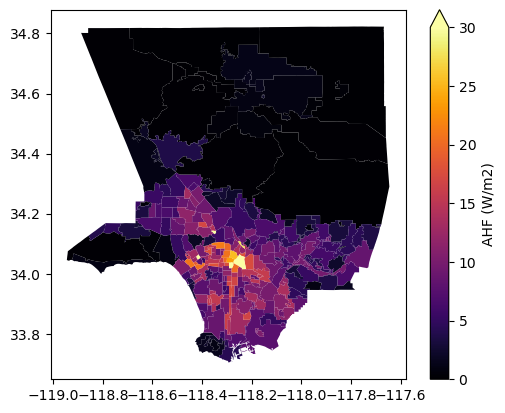

In [51]:
# plot heatmap of neighborhood AHF
stats = df.describe()
stats_t = stats.T
ahf_hoods_gdf = neighborhoods.merge(stats_t, on = 'name')
drop_col_list = ['external_i', 'location', 'latitude', 'slug_1', 'sqmi',
       'display_na', 'set', 'slug', 'longitude', 'name_1', 'kind', 'type']
ahf_hoods_gdf.drop(columns=drop_col_list, inplace=True)
ahf_hoods_gdf.plot(column='mean', cmap='inferno', legend=True,
                  vmin=0, vmax = 30, 
                  legend_kwds={
                     'label':'AHF (W/m2)',
                     'extend':'max'
                  })

# Default - Control

Assuming deltas have been pre-computed and saved using `deltas-analysis.py` script.

In [ ]:
# import deltas data
deltas = {}
data_dir = '/home1/kojoseph/ah-la-paper/data/deltas-urban-wrf'
nc_files = glob.glob(f"{data_dir}/*.nc")
for f in nc_files:
    filename = os.path.basename(f)
    delta_id = filename.split('.')[0]
    ds = xr.open_dataset(f)
    deltas[delta_id] = ds

## T2 (2 meter air temperature)

In [ ]:
# Diurnal plot for delta(T2)
v = 'T2'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(del_ta_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(0, 0.5)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-t2-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

In [ ]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-0.5, 1.5)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_ta_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist-t2-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [ ]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

## TC_URB (canopy air temperature)

In [ ]:
# Diurnal plot for delta(T2)
v = 'TC_URB'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(del_tc_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(0, 2.5)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-tc-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")         

In [ ]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-0.5, 4.0)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(del_tc_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist-tc-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [ ]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

## WS (Wind Speed)

In [ ]:
# Diurnal plot for delta(T2)
v = 'WS'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(ws_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(-0.1, 0.2)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-ws-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)            

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

In [ ]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-1.0, 1.0)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta_dict[m] = deltas[delta_id][v]
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]
# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(ws_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# save plot
save_filename = 'hist-ws-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [ ]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

## PBL

In [ ]:
# Diurnal plot for delta(T2)
v = 'PBLH'
mean_dict = {}
ci_lower = {}
ci_upper = {}
months = [8, 12]
target = 'ah_default'
control = 'ah_off'
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    mean = deltas[delta_id][v].mean(dim=['y', 'x'], skipna=True)
    mean_diurnal = mean.groupby('hour').mean('Time')
    std_diurnal = mean.groupby('hour').std('Time')
    n_sample = len(mean[mean['hour']==0])
    err_diurnal = 1.96*(std_diurnal/(n_sample)**(1/2))
    mean_dict[m] = mean_diurnal
    ci_lower[m] = mean_diurnal - err_diurnal
    ci_upper[m] = mean_diurnal + err_diurnal
# initiate plot
fig, ax = plt.subplots(figsize=(6,4))
hrs = range(24)
# summer
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.errorbar(
    hrs,
    mean_dict[8].values,
    yerr=[mean_dict[8].values - ci_lower[8].values, ci_upper[8].values - mean_dict[8].values],
    fmt='o-', color=max_red, label='Summer', linewidth=3, alpha=0.7, capsize=4, capthick=2
)
# winter
ax.errorbar(
    hrs,
    mean_dict[12].values,
    yerr=[mean_dict[12].values - ci_lower[12].values, ci_upper[12].values - mean_dict[12].values],
    fmt='o-', color=yale_blue, label='Winter', linewidth=3, alpha=0.7, capsize=4, capthick=2
)

ax.xaxis.set_ticks(np.arange(0,24,3))
ax.grid(linewidth=0.5, alpha=0.7, linestyle='--')
ax.set_xlabel('Hour of Day')
ax.set_ylabel(pblh_label)
ax.legend()
ax.set_xlim(0, 23)
ax.set_ylim(-50, 120)
ax.annotate('whiskers = 95% CI', xy=(0.5, 0.9), xycoords='axes fraction', 
            fontsize=10, horizontalalignment='center', verticalalignment='bottom')

# save plot
save_filename = 'diurnal-lineplot-pbl-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

# Print the max value and time of max value
# For summer (month 8)
max_idx_summer = np.argmax(mean_dict[8].values)
max_hour_summer = mean_dict[8]['hour'].values[max_idx_summer]
max_val_summer = mean_dict[8].values[max_idx_summer]
min_idx_summer = np.argmin(mean_dict[8].values)
min_hour_summer = mean_dict[8]['hour'].values[min_idx_summer]
min_val_summer = mean_dict[8].values[min_idx_summer]
print(f"Summer: Max mean at hour {max_hour_summer} with value {max_val_summer:.3f}")
print(f"Summer: Min mean at hour {min_hour_summer} with value {min_val_summer:.3f}")

# For winter (month 12)
max_idx_winter = np.argmax(mean_dict[12].values)
max_hour_winter = mean_dict[12]['hour'].values[max_idx_winter]
max_val_winter = mean_dict[12].values[max_idx_winter]
min_idx_winter = np.argmin(mean_dict[12].values)
min_hour_winter = mean_dict[12]['hour'].values[min_idx_winter]
min_val_winter = mean_dict[12].values[min_idx_winter]
print(f"Winter: Max mean at hour {max_hour_winter} with value {max_val_winter:.3f}")
print(f"Winter: Min mean at hour {min_hour_winter} with value {min_val_winter:.3f}")

Note: for histograms and statistical tests, coarsen PBL to 10km first. 

In [ ]:
# Distribution of deltas
fig, ax = plt.subplots(figsize=(6,3))
xlim = (-50, 100)
# get data
delta_dict = {}
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    ds = deltas[delta_id][v]
    ds = ds.coarsen(y=10, x=10, boundary='trim').mean() # coarsen to 10km
    delta_dict[m] = ds
delta_summer = delta_dict[8].values.flatten()
delta_summer = delta_summer[~np.isnan(delta_summer)]
delta_winter = delta_dict[12].values.flatten()
delta_winter = delta_winter[~np.isnan(delta_winter)]

# Summer: filled histogram with transparent fill, no edge
n_s, bins_s, patches_s = ax.hist(
    delta_summer, bins='auto', range=xlim, label='Summer',
    histtype='stepfilled', density=True,
    facecolor=(1, 0, 0, 0.3), edgecolor='none'
)
# Summer: edges with higher opacity
ax.hist(
    delta_summer, bins=bins_s, range=xlim,
    histtype='step', density=True,
    color=max_red, linewidth=2, alpha=1
)

# Winter: filled histogram with transparent fill, no edge
n_w, bins_w, patches_w = ax.hist(
    delta_winter, bins='auto', range=xlim, label='Winter',
    histtype='stepfilled', density=True,
    facecolor=(0, 0, 1, 0.3), edgecolor='none'
)
# Winter: edges with higher opacity
ax.hist(
    delta_winter, bins=bins_w, range=xlim,
    histtype='step', density=True,
    color=yale_blue, linewidth=2, alpha=1
)

# Plot mean as lines
mean_val_s = np.mean(delta_summer)
mean_val_w = np.mean(delta_winter)
plt.axvline(mean_val_s, color=max_red, linestyle='--', label=f'Mean = {mean_val_s:.2f}')
plt.axvline(mean_val_w, color=yale_blue, linestyle='--', label=f'Mean = {mean_val_w:.2f}')

# ax.grid(linewidth=0.5, alpha=0.3, linestyle='--')
ax.set_xlabel(pblh_label)
ax.set_ylabel('Density')
ax.legend()
ax.axvline(x=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_title('')
ax.set_xlim(xlim)
# ax.set_yscale('log')  # <-- Add this line for log scale on y-axis
# save plot
save_filename = 'hist-pbl-default.png'
save_filepath = os.path.join(plot_dir, save_filename)
plt.tight_layout()
plt.savefig(save_filepath, dpi=300)

In [ ]:
# Statistical tests
for m in months:
    delta_id = f'{control}-{target}-{m:02d}'
    delta = deltas[delta_id]
    delta = delta.coarsen(y=10, x=10, boundary='trim').mean() # coarsen to 10km
    delta_values = delta[v].values.flatten()
    delta_values = delta_values[~np.isnan(delta_values)]
    print(f'=== Statistical test for {v} for month {m} ===')
    
    # Paired t-test
    t_stat, p_value = stats.ttest_1samp(delta_values, popmean=0)
    if p_value < 1e-16:
        print(f"t-statistic: {t_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"t-statistic: {t_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")

    # Wilcoxon signed-rank test
    w_stat, p_value = stats.wilcoxon(delta_values)
    if p_value < 1e-16:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: < 1e-16")
    else:
        print(f"Wilcoxon statistic: {w_stat:.2e}, p-value: {p_value:.2e}")
    if p_value < 0.001:
        print(">>> Result: Statistically significant at p < 0.001 (very strong evidence against null hypothesis)")
    elif p_value < 0.01:
        print(">>> Result: Statistically significant at p < 0.01 (strong evidence against null hypothesis)")
    elif p_value < 0.05:
        print(">>> Result: Statistically significant at p < 0.05 (moderate evidence against null hypothesis)")
    else:
        print(">>> Result: Not statistically significant (p >= 0.05)")